In [1]:
import glob
import os
import cPickle as pickle
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all the tables
table_path = '../data/WikiTableQuestions/csv/'

def clean_text(s):
    return s.lower().replace('\\n', ' ').replace('\n', '')
    
def read_table(filename, path=table_path, delimiter='\t'):
    ''' given the path and file name of certain table, 
        return a dictionary with {head-title: [elements]} 
    '''
    result = {}
    with open(path+filename, 'r') as f:
        heads, head_index = f.readline().split(delimiter), []
        for head in heads:
            head = clean_text(head)
            result[head] = []
            head_index.append(head)
        
        for line in f:
            for head, ele in zip(head_index, line.split(delimiter)):
                ele = clean_text(ele)
                result[head].append(ele)
    return result

def read_all_tables(table_path=table_path):
    all_tables = {}
    for path in glob.glob(table_path+'*'):
        csv_path = path[-7:]
        for f in glob.glob(table_path+csv_path+'/*.tsv'):
            filename = f.split('/')[-1]
            context = 'csv/{0}/{1}csv'.format(csv_path, filename[:-3])
            table = read_table(csv_path + '/' + filename)
            all_tables[context] = table
    return all_tables

all_tables = read_all_tables()

In [3]:
def find_answer(answer, table):
    ''' return answer_position: {column name: [row indices]}
    '''
    result = {}
    for head in table:
        indices = [i for i, text in enumerate(table[head]) if text==answer.lower()]
        if len(indices)!=0:
            result[head] = indices
    return result

def process_syntax(syntax):
    result = {}
    for index, info in enumerate(syntax[1]):
        result[index] = {'word': info[0], 'tag': info[1], 'pos': info[2], 
                         'role': info[3], 'parent': None, 'children': []}
    for index, children in enumerate(syntax[2]):
        for child in children:
            result[index]['children'].append(child)
            result[child]['parent'] = index
    return result
    
def question_preprocess(loadfile, savefile):
    with open(loadfile, 'rb') as f:
        data = pickle.load(f)
    result = {}
    for info in data:
        id, question, table_id, answer, syntax = info
        answer_position = find_answer(answer, all_tables[table_id])
        syntax = process_syntax(syntax)
        result[id] = {
            'question': question,
            'table_id': table_id,
            'answer': answer,
            'answer_position': answer_position,
            'syntax': syntax
        }
    with open(savefile, 'wb') as f:
        pickle.dump(result, f)
    return result

In [4]:
syntaxnet = '../data/questions_syntaxnet/'
questions = '../data/PreprocessedQuestions/'
files = ['training.pkl', 'seen-tables.pkl', 'unseen-tables.pkl']
for filename in files:
    question_preprocess(syntaxnet+filename, questions+filename)

In [5]:
# how to load data + data schema
with open('../data/PreprocessedQuestions/training.pkl', 'rb') as f:
    data = pickle.load(f)
data[data.keys()[0]]

{'answer': 'Astarto',
 'answer_position': {'title': [16]},
 'question': 'which opera has the most acts, la fortezza al cimento or astarto?',
 'syntax': {0: {'children': [],
   'parent': 1,
   'pos': 'WDT',
   'role': 'det',
   'tag': 'DET',
   'word': 'which'},
  1: {'children': [0],
   'parent': 2,
   'pos': 'NN',
   'role': 'nsubj',
   'tag': 'NOUN',
   'word': 'opera'},
  2: {'children': [1, 5, 13],
   'parent': None,
   'pos': 'VBZ',
   'role': 'ROOT',
   'tag': 'VERB',
   'word': 'has'},
  3: {'children': [],
   'parent': 5,
   'pos': 'DT',
   'role': 'det',
   'tag': 'DET',
   'word': 'the'},
  4: {'children': [],
   'parent': 5,
   'pos': 'JJS',
   'role': 'amod',
   'tag': 'ADJ',
   'word': 'most'},
  5: {'children': [3, 4, 6, 10],
   'parent': 2,
   'pos': 'NNS',
   'role': 'dobj',
   'tag': 'NOUN',
   'word': 'acts'},
  6: {'children': [],
   'parent': 5,
   'pos': ',',
   'role': 'punct',
   'tag': '.',
   'word': ','},
  7: {'children': [],
   'parent': 10,
   'pos': 'FW',


# Task 1 - Find the correct column

In [6]:
# load word embedding
word_vectors = {}
with open('../glove.840B.300d.txt', 'r') as f:
    i = 0
    for line in f:
        i += 1
        if i % 100000==0: 
            clear_output()
            print 'Processing {0}th word'.format(i)
        info = line.split()
        word_vectors[info[0]] = np.array([float(x) for x in info[1:]])

Processing 2100000th word


In [7]:
# find the 'W*' word, return the index
def find_w(syntax):
    for index in syntax:
        if syntax[index]['pos'][0] == 'W':
            return index
    return -1 # could not find w word

# find the 'nearest' noun of 'W*' word
def find_answer_noun(syntax):
    w_index = find_w(syntax)
    if syntax[w_index]['pos'][0] == 'N':
        return w_index
    
    parent = syntax[w_index]['parent']
    children = syntax[w_index]['children']
    que = children
    if parent != None:
        que.append(parent)
    visited = [w_index]
    while len(que) != 0:
        index = que.pop(0)
        if index == None: continue
        if index not in visited:
            visited.append(index)
            if syntax[index]['pos'][0] == 'N':
                return index
        new_child = syntax[index]['children']
        for child in new_child:
            if child not in visited:
                que.append(child)
        new_parent = syntax[index]['parent']
        if new_parent not in visited:
            que.append(new_parent)
    return -1 # cound not find closest noun

# for different 'W*' word, given the object key word
def find_object_word(syntax):
    w_index = find_w(syntax)
    if w_index == -1: return ''
    
    w_word = syntax[w_index]['word']
    if w_word == 'when': return 'year'
    if w_word == 'who': return 'name'
    if w_word == 'where': return 'location'
    #if w_word == 'how':
    #    words = ['many', 'much']
    #    if syntax[w_index+1]['word'] in words: return 'number'
    
    index = find_answer_noun(syntax)
    if index == -1: return ''
    
    return syntax[index]['word']

In [8]:
def cosine_similarity(w1, w2, word_vectors=word_vectors):
    w1, w2 = w1.lower().split(), w2.lower().split()
    dist = 0.0
    for ww1 in w1:
        if ww1 not in word_vectors: continue
        for ww2 in w2:
            if ww1 == ww2: return 1.0
            if ww2 not in word_vectors: continue
            v1, v2 = word_vectors[ww1], word_vectors[ww2]
            product = np.dot(v1,v2)
            length = np.sqrt(np.dot(v1,v1)*np.dot(v2,v2))
            if length == 0: return 1.0
            dist = max(dist, product/length)                
    return dist

def distance_similarity(w1, w2, word_vectors=word_vectors):
    w1, w2 = w1.lower(), w2.lower()
    if w1==w2: return float('inf')
    if w1 not in word_vectors or w2 not in word_vectors:
        return 0.0
    v1, v2 = word_vectors[w1], word_vectors[w2]
    return 1.0/max(0.01, np.sqrt(np.sum((v1-v2)**2)))

In [9]:
def rank_head_answer_noun_similarity(question, similarity_function = cosine_similarity):
    syntax = question['syntax']
    answer_noun = find_object_word(syntax)
    
    if question['answer_position'] == {}:
        return (-1, None, answer_noun)
    elif answer_noun == '':
        return (-2, None, '')
    
    head = question['answer_position'].keys()[0]
    similarity = similarity_function(answer_noun, head)
    
    result = (-1, None, answer_noun)
    for h in all_tables[question['table_id']].keys():
        sim = similarity_function(answer_noun, h)
        if sim >= similarity: 
            result = (result[0]+1, h, answer_noun)
    if result[1].lower()==head.lower():
        result = (0, head, answer_noun)
    #w_index = find_w(syntax)
    #w_word = syntax[w_index]['word']
    #print w_word, result
    return result

def rank_distribution(questions):
    return [(id, rank_head_answer_noun_similarity(question)) for id, question in questions.items()]

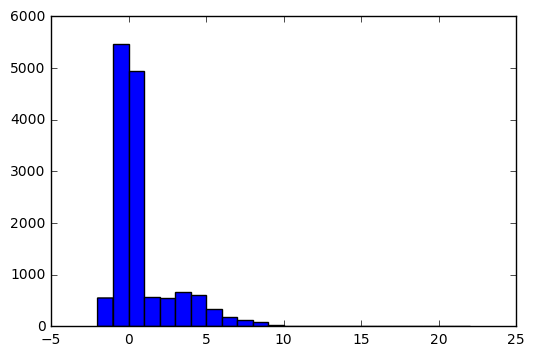

In [10]:
# Brief Analysis 
with open('../data/PreprocessedQuestions/training.pkl', 'rb') as f:
    data = pickle.load(f)
dist = rank_distribution(data)
x = [a[1][0] for a in dist]
_ = plt.hist(x, bins=max(x)-min(x))

# -1: answer cannot be directly found
# -2: can't find w word or can't find answer noun

In [11]:
questions_path = '../data/PreprocessedQuestions/'
files = ['training.pkl', 'seen-tables.pkl', 'unseen-tables.pkl']
column_rank = {}
for filename in files:
    with open(questions_path+filename, 'rb') as f:
        data = pickle.load(f)
    dist = rank_distribution(data)
    
    column_rank[filename[:-4]] = dist
    
    x = [a[1][0] for a in dist]
    
    count_nouns = 0
    count_ans = 0
    
    for number in x:
        if number < 0:
            count_nouns += 1
        else:
            count_ans += 1
    
    print 'We could correctly find {0:.1f}% of clolumns in {1}.'.format(100*float(sum(np.array(x)==0))/count_ans, filename[:-4])
    print '\t', sum(np.array(x)<0), sum(np.array(x)==0), sum(np.array(x)>0)
    print

We could correctly find 60.8% of clolumns in training.
	6015 4948 3189

We could correctly find 60.5% of clolumns in seen-tables.
	1536 1210 791

We could correctly find 60.5% of clolumns in unseen-tables.
	1851 1508 985



In [12]:
# The questions that get wrong columns
def str_question_with_wrong_columns(question, result):
    if result[0]==0:
        return None
    if result[0]<0:
        return None
    return 'Answer Column: {0}, Predict Column: {1}, Rank: {2}'.format(
        question['answer_position'].keys()[0], result[1], result[0]+1)

def debug(filename):
    with open(questions_path+filename, 'rb') as f:
        data = pickle.load(f)
    print filename[:-4], ':'

    w_list = ['who', 'when', 'what', 'where', 'how', 'why']
    w_dict = {'who':0, 'when':0, 'what':0, 'where':0, 'how':0, 'why':0, 'other':0}
    w_dict_wrong = {'who':0, 'when':0, 'what':0, 'where':0, 'how':0, 'why':0, 'other':0}
    
    for id, result in column_rank[filename[:-4]]:
        question = data[id]
        debug_str = str_question_with_wrong_columns(question, result)
        w_word = question['syntax'][0]['word']
            
        if result[0] == 0:
            if w_word in w_list:
                w_dict[w_word]+=1
            else:
                w_dict['other']+=1
        if debug_str is not None:
            if w_word in w_list:
                w_dict_wrong[w_word]+=1
            else:
                w_dict_wrong['other']+=1
            #print ' Question id: ' + id
            #print ' \tAnswer Noun: ' + result[2]
            #print ' \t' + debug_str
            #print ' \t' + question['question']
            #print
    for key in w_dict:
        print key, w_dict[key], w_dict_wrong[key]

In [13]:
filename = 'training.pkl'
debug(filename)

training :
what 1666 834
who 577 449
when 85 17
how 480 996
other 2093 877
where 47 15
why 0 1


In [14]:
filename = 'seen-tables.pkl'
debug(filename)

seen-tables :
what 417 199
who 136 121
when 27 3
how 114 236
other 506 226
where 10 6
why 0 0


In [15]:
filename = 'unseen-tables.pkl'
debug(filename)

unseen-tables :
what 489 238
who 188 186
when 32 5
how 187 303
other 590 251
where 22 2
why 0 0


# Find the answer (clue column)

In [16]:
def findClueList(syntax, key_word):
    noun_list = []
    # Find all of the nouns in the sentence
    for key in syntax:
        if syntax[key]['pos'][0] == 'N' and syntax[key]['word'] != key_word:
            noun_list.append(syntax[key]['word'])
        #if syntax[key]['word'] != key_word:
        #    noun_list.append(syntax[key]['word'])
    return noun_list
    
def findNearestCluePair(clue_list, col_list, similarity_function = cosine_similarity):
    cos_dist, clue_word, column_word = 0.0, '', ''
    for clue in clue_list:
        for column in col_list:
            dist = similarity_function(clue, column)
            if dist > cos_dist:
                cos_dist, clue_word, column_word = dist, clue, column
    return clue_word, column_word

def findAns(question, column, key_word):    
    ans_table = all_tables[question['table_id']]
    ans_column = ans_table[column]
    syntax = question['syntax']
    
    clue_list = findClueList(syntax, key_word)
    column_list = ans_table.keys()
    column_list.remove(column)
    clue_word, clue_column = findNearestCluePair(clue_list, column_list)
    
    if clue_column == '': return '', question['answer']
    clue_column_list = ans_table[clue_column]
    max_similar, ans_index = 0.0, 0
    for index, clue_cell in enumerate(clue_column_list):
        cos_dist = cosine_similarity(clue_word, clue_cell)
        if cos_dist >= max_similar and index < len(ans_column):
            max_similar, ans_index = cos_dist, index 
    return ans_column[ans_index], question['answer']

In [17]:
def printResult(filename, n_a, wrong_column, wrong_answer, right_answer):
    print filename
    print '  {}% of questions with correct column have correct answer.'.format(float(right_answer)/(wrong_answer+right_answer)*100)
    print '  {}% of questions have correct column.'.format(float(wrong_answer+right_answer)/(wrong_answer+right_answer+wrong_column)*100) 
    print '  {}% of questions have correct answer.'.format(float(right_answer)/(wrong_answer+right_answer+wrong_column)*100)
    print '  Right answer: {}'.format(right_answer)
    print '  Wrong answer: {}'.format(wrong_answer)
    print '  Not the correct column: {}'.format(wrong_column)
    print '  Not applicable: {}'.format(n_a)
    
def answerQuestions(questions):
    n_a, wrong_column, wrong_answer, right_answer = 0, 0, 0, 0
    for id, question in questions.items():
        rank, column, key_word = rank_head_answer_noun_similarity(question)
        if rank < 0:
            n_a += 1
        elif rank > 0:
            wrong_column += 1
        else: # rank == 0
            found, real = findAns(question, column, key_word)
            if found.lower() == real.lower():
                right_answer += 1
            else:
                wrong_answer += 1
    return (n_a, wrong_column, wrong_answer, right_answer)

def processFiles(questions_path, files):    
    for filename in files:        
        with open(questions_path+filename, 'rb') as f:
            questions = pickle.load(f)
        n_a, wrong_column, wrong_answer, right_answer = answerQuestions(questions)
        printResult(filename, n_a, wrong_column, wrong_answer, right_answer)
    return 0                                                       

In [18]:
questions_path = '../data/PreprocessedQuestions/'
files = ['training.pkl', 'seen-tables.pkl', 'unseen-tables.pkl']
processFiles(questions_path, files)

training.pkl
  13.2174616006% of questions with correct column have correct answer.
  60.8086518373% of questions have correct column.
  8.03736020646% of questions have correct answer.
  Right answer: 654
  Wrong answer: 4294
  Not the correct column: 3189
  Not applicable: 6015
seen-tables.pkl
  14.3801652893% of questions with correct column have correct answer.
  60.4697651174% of questions have correct column.
  8.69565217391% of questions have correct answer.
  Right answer: 174
  Wrong answer: 1036
  Not the correct column: 791
  Not applicable: 1536
unseen-tables.pkl
  15.3846153846% of questions with correct column have correct answer.
  60.4893702367% of questions have correct column.
  9.30605695949% of questions have correct answer.
  Right answer: 232
  Wrong answer: 1276
  Not the correct column: 985
  Not applicable: 1851


0